# Quick Reference for Midterm 2
The major parts of Tutorials 5-6 and the practice midterm

In [2]:
require(car)
require(Hmisc)
require(stats)
require(psych)

Loading required package: Hmisc
Warning message:
"package 'Hmisc' was built under R version 3.4.3"Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: psych

Attaching package: 'psych'

The following object is masked from 'package:Hmisc':

    describe

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'package:car':

    logit



In [18]:
df = ToothGrowth

## Model Creation

In [24]:
mod0 = lm(len ~1, data=df) #Mean model
print(length(coef(mod0)))
#1 parameter

mod1 = lm(len ~ dose, data=df) #Single line, single intercept model
print(length(coef(mod1)))
# 2 parameters (intercept, slope)

mod2 = lm(len ~ supp + dose, data=df) #Double line, two intercepts
print(length(coef(mod2)))
#3 parameters

mod3 = lm(len ~supp*dose, data=df) #Double line, two intercepts, two slopes
print(length(coef(mod3)))
#4 parameters

[1] 1
[1] 2
[1] 3
[1] 4


### Scatterplots 

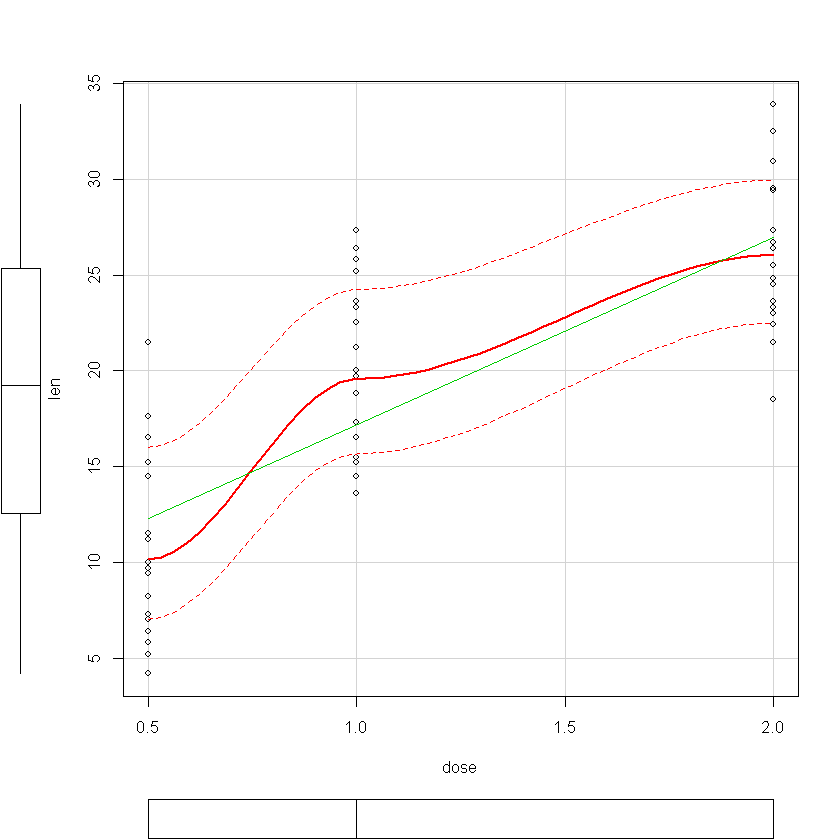

In [20]:
#Of just one term
scatterplot(len~dose, data=ToothGrowth)

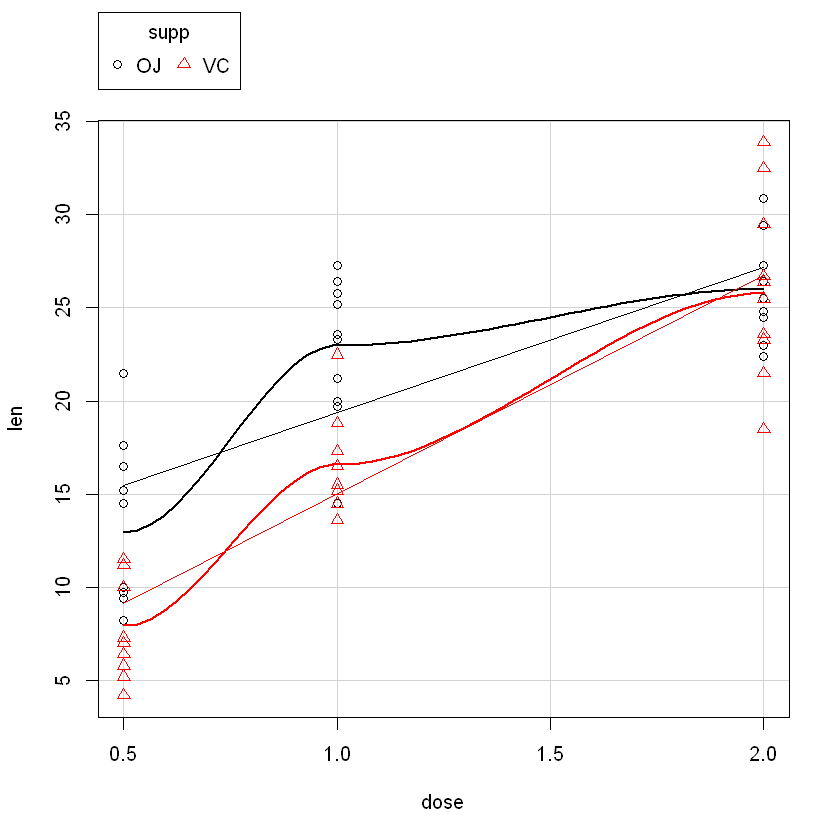

In [21]:
#Of all data, with interaction
scatterplot(len~dose*supp, data=ToothGrowth)

## Calculating R2, R2 Adj, F-stat and P Value

Getting it directly for a model:

In [34]:
#R2 and R2 adjusted
summary(mod3)$adj.r.squared
summary(mod3)$r.squared

#F statistic and P values
anova(mod3, mod0)

[1] 0.7150662

[1] 0.7295544

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
56,933.6349,NA,NA,NA,NA
59,3452.2093,-3,-2518.574,50.35522,6.520791e-16


In [38]:
# Equivalent to:
summary(aov(len~dose*supp, data=df))

            Df Sum Sq Mean Sq F value   Pr(>F)    
dose         1 2224.3  2224.3 133.415  < 2e-16 ***
supp         1  205.3   205.3  12.317 0.000894 ***
dose:supp    1   88.9    88.9   5.333 0.024631 *  
Residuals   56  933.6    16.7                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [39]:
summary(lm(len~dose*supp, data=df))


Call:
lm(formula = len ~ dose * supp, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2264 -2.8462  0.0504  2.2893  7.9386 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   11.550      1.581   7.304 1.09e-09 ***
dose           7.811      1.195   6.534 2.03e-08 ***
suppVC        -8.255      2.236  -3.691 0.000507 ***
dose:suppVC    3.904      1.691   2.309 0.024631 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.083 on 56 degrees of freedom
Multiple R-squared:  0.7296,	Adjusted R-squared:  0.7151 
F-statistic: 50.36 on 3 and 56 DF,  p-value: 6.521e-16


### R2 and R2 adjusted

In [29]:
y_hat_full = predict(mod3)
y_hat_null =  predict(mod0)

ss3 = sum((df$len - y_hat_full)^2)
ss0 = sum((df$len - y_hat_null)^2)

R2 = 1 - (ss3/ss0)
print(R2)

[1] 0.7295544


In [30]:
n = length(mod3$model$len)
k = length(mod3$coefficients)

R2adj = 1 - (ss3/(n-k))/(ss0/(n-1))
print(R2adj)

[1] 0.7150662


### F-statistic and p-value

In [31]:
F_val = ((ss0 - ss3)/(k-1))/((ss3)/(n-k))
print(F_val)

[1] 50.35522


In [32]:
require(stats)
pfval = 1 - pf(F_val, df1 = (k-1), df2 = n-k)
print(pfval)

[1] 6.661338e-16


## Cross validation (R2 cross-validated)

Prepare data for cross validation

In [107]:
nCV <- 10

R2cvs_mod1 <- numeric(nCV)
R2cvs_mod2 <- numeric(nCV)
R2cvs_mod3 <- numeric(nCV)
R2cvs_mod3_vs_mod1 = numeric(nCV)

folds <- cut(sample(nrow(df)),breaks=nCV,labels=FALSE)

Perform 10-fold cross validation

In [109]:
#Perform n.folds fold cross validation
for(i in 1:nCV){
    #Segment your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- ToothGrowth[testIndexes, ]
    trainData <- ToothGrowth[-testIndexes, ]
    
    # The three models
    mod1_cv <- lm(len ~ dose, data=trainData)
    mod2_cv <- lm(len ~ dose + supp, data=trainData)
    mod3_cv <- lm(len ~ dose*supp, data=trainData)
    
    # Get predictions
    yhat_mod1_cv <- predict(mod1_cv, newdata = testData)
    yhat_mod2_cv <- predict(mod2_cv, newdata = testData)
    yhat_mod3_cv <- predict(mod3_cv, newdata = testData)
    mean_cv <- mean(testData$len)

    # Calculate R2
    SStot <- sum((testData$len - mean_cv)^2)
    SSE_mod1 <- sum((testData$len - yhat_mod1_cv)^2)
    SSE_mod2 <- sum((testData$len - yhat_mod2_cv)^2)
    SSE_mod3 <- sum((testData$len - yhat_mod3_cv)^2)
    
    #this finds R2cvs
    R2cvs_mod1[i] <- (SStot-SSE_mod1)/SStot
    R2cvs_mod2[i] <- (SStot-SSE_mod2)/SStot
    R2cvs_mod3[i] <- (SStot-SSE_mod3)/SStot
    
    #This finds the R2 cv comparing models 1 and 3 (from Tutorial 6)
    R2cvs_mod3_vs_mod1[i] = 1-SSE_mod3/SSE_mod1
}

### Find mean R2 CVs

In [46]:
R2cvs <- c( mean(R2cvs_mod1), mean(R2cvs_mod2), mean(R2cvs_mod3) ) 

In [47]:
R2cvs

[1] 0.4461823 0.5404114 0.5874036

### Standard error for Cross-validated R2
Standard error = sd(R2_cvs)/sqrt(number_folds)

N in this case is the number of different R2_cvs you calculated! Not the overall sample size!

In [48]:
R2cvs_SE <- c( sd(R2cvs_mod1)/sqrt(nCV), sd(R2cvs_mod2)/sqrt(nCV), mean(R2cvs_mod3)/sqrt(nCV) ) 

In [50]:
R2cvs_SE

[1] 0.1633283 0.1233900 0.1857533

### Graph R2 cv as a function of number of model parameters

In [52]:
param_ct = c(length(coef(mod1_cv)), length(coef(mod2_cv)), length(coef(mod3_cv)))
param_ct

[1] 2 3 4

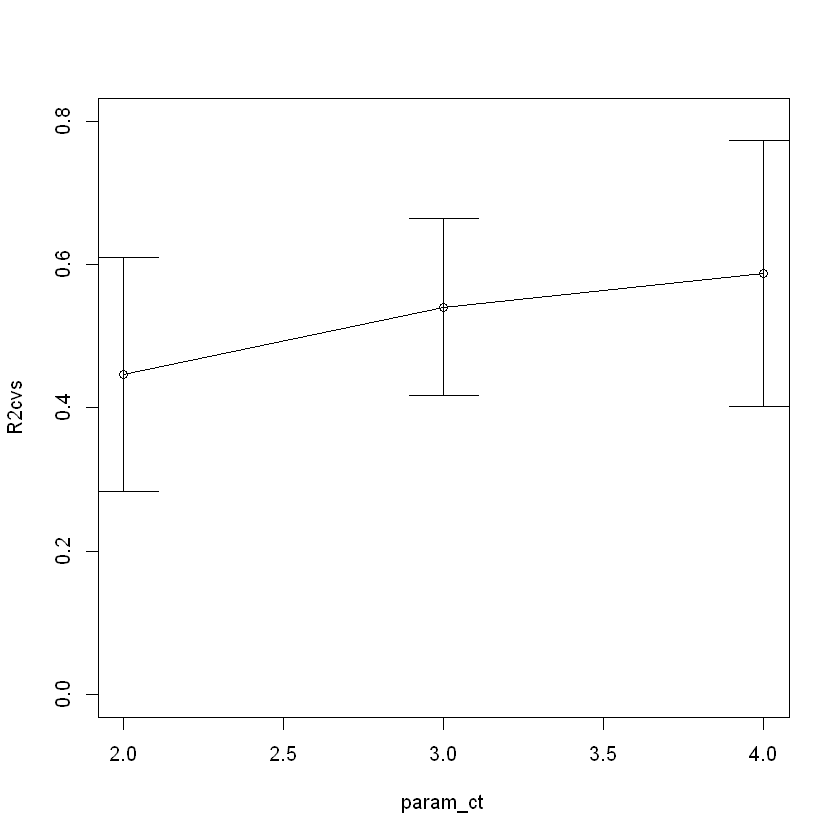

In [63]:
require(Hmisc)
plot(param_ct, R2cvs, type="l", ylim=c(0,.8)) #plot parameters vs R2cv
errbar(param_ct, R2cvs, R2cvs+R2cvs_SE, R2cvs-R2cvs_SE, add=T, pch=1, cap=.1) 
#add error bars for standard error

## Model comparison

### Cross-validated model comparison

In [110]:
print(sprintf('Rcv 1 Line %.3f +- %.3f', mean(R2cvs_mod1), 2.0*sd(R2cvs_mod1)/sqrt(nCV) ))
print(sprintf('Rcv 2 Line %.3f +- %.3f', mean(R2cvs_mod3), 2.0*sd(R2cvs_mod3)/sqrt(nCV) ))

[1] "Rcv 1 Line 0.514 +- 0.208"
[1] "Rcv 2 Line 0.600 +- 0.144"


In [67]:
mean(R2cvs_mod1) + 2.0*sd(R2cvs_mod1)/sqrt(nCV)

[1] 0.7728388

In [69]:
mean(R2cvs_mod3) - 2.0*sd(R2cvs_mod3)/sqrt(nCV)

[1] 0.3930849

There is significant overlap in the cross-validated R2 for both models, so there is not a significant difference. 

Not significant if: 
        Mean R2CV for worse model + 2 x SE is greater than or equal to Mean R2CV for better model + 2 x SE

### Summary
This lets you get the mean of a statistic, as well as the standard error of that statistic (ie sd in this case)

IF R2 cv is different from 0, then you know. Use your standard error - 2*standard error (ie standard deviation) is 5%. 
So take the R2 cv and subtract sd(R2cv)*2 (remember sd(R2cv)=SE)

Rule of thumb -- need a minimum of 10 df on your testing df -- ie if you are training one with 5 you need 50 

This is another way to visualize these statistics -- it lets you see the 95% confidence interval and mean of your cross validated R2 estimates easily
if the tail hit 0 then that would be bad!


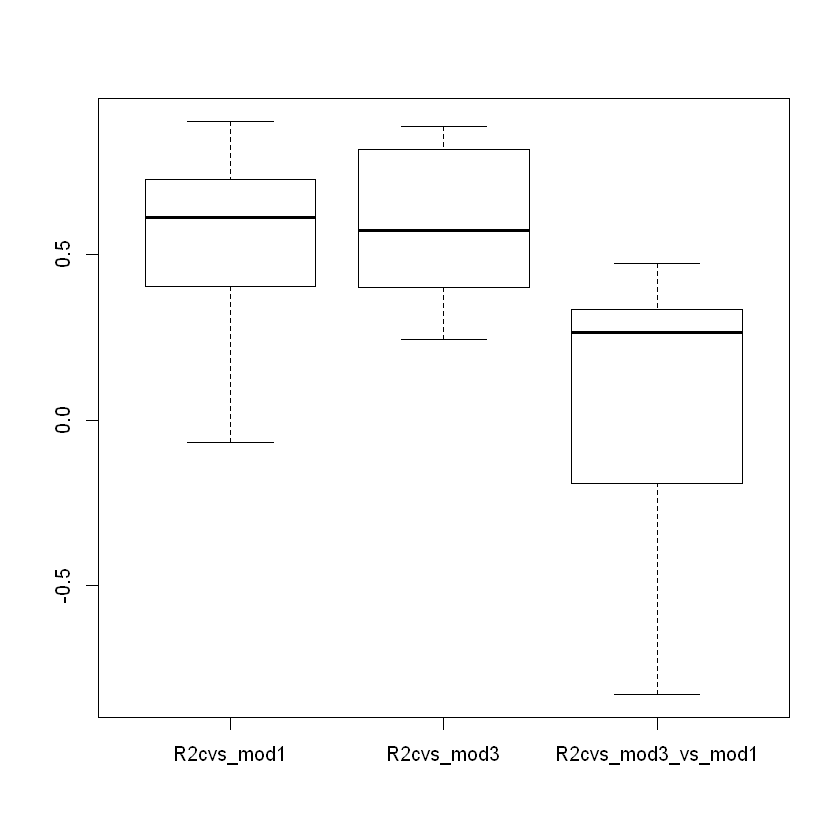

In [112]:
boxplot(cbind(R2cvs_mod1, R2cvs_mod3, R2cvs_mod3_vs_mod1))
#You can see that the tail is well below zero of the compared R2, 
#and that there is huge overlap between them

### Traditional model comparison (ANOVAs)

In [64]:
#comparing the model with only one line vs. one with 2 lines with difft intercepts
anova(mod1, mod3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
58,1227.9050,NA,NA,NA,NA
56,933.6349,2,294.2701,8.825251,0.0004659558


Under traditional model comparison, the model with more terms is significantly better -- the F-statistic is 8, giving a p-value of less than .05

Additionally, the Adjusted R2 for both models are much higher with traditional statistics than with their cross validated equivalents

In [74]:
summary(mod1)$adj.r.squared

[1] 0.6381807

In [75]:
mean(R2cvs_mod1)

[1] 0.4461823

In [73]:
summary(mod3)$adj.r.squared

[1] 0.7150662

In [77]:
mean(R2cvs_mod3)

[1] 0.5874036

## Discussion of ANOVAs

In [99]:
#1) Best choice is direct comparison
anova(mod0,mod3)
#2) Type I Anova
anova(mod3)
#3) Type II Anova
Anova(mod3, type="II")
#4) Get results of anova(model, null_model) from summary of lm()
summary(mod3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
59,3452.2093,NA,NA,NA,NA
56,933.6349,3,2518.574,50.35522,6.520791e-16


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
supp,1,205.35000,205.35000,12.317020,8.936452e-04
dose,1,2224.30430,2224.30430,133.415146,1.907985e-16
supp:dose,1,88.92011,88.92011,5.333483,2.463136e-02
Residuals,56,933.63493,16.67205,NA,NA


,Sum Sq,Df,F value,Pr(>F)
supp,205.35000,1,12.317020,8.936452e-04
dose,2224.30430,1,133.415146,1.907985e-16
supp:dose,88.92011,1,5.333483,2.463136e-02
Residuals,933.63493,56,NA,NA



Call:
lm(formula = len ~ supp * dose, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2264 -2.8462  0.0504  2.2893  7.9386 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   11.550      1.581   7.304 1.09e-09 ***
suppVC        -8.255      2.236  -3.691 0.000507 ***
dose           7.811      1.195   6.534 2.03e-08 ***
suppVC:dose    3.904      1.691   2.309 0.024631 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.083 on 56 degrees of freedom
Multiple R-squared:  0.7296,	Adjusted R-squared:  0.7151 
F-statistic: 50.36 on 3 and 56 DF,  p-value: 6.521e-16


### Two way ANOVA

In [102]:
#This is a two way anova with an interaction
summary(aov(len ~ supp*dose, data=df))

            Df Sum Sq Mean Sq F value   Pr(>F)    
supp         1  205.4   205.4  12.317 0.000894 ***
dose         1 2224.3  2224.3 133.415  < 2e-16 ***
supp:dose    1   88.9    88.9   5.333 0.024631 *  
Residuals   56  933.6    16.7                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

### Type I ANOVAs (AKA Stepwise regression)

In [97]:
#This does tests in succession, adding additional variables. It is also known as step-wise regression
# It is vulnerable to the order in which you do the comparisons, so it isn't in favor

# The anova command (fom the stats library) shows sequential F values. This hypothesis
# testing is sometimes called a Type I anova. In a Type I ANOVA, also called a sequential
# ANOVA, a series of models are fit, and the *difference* in sum-of-square error between
# each model is reported in the summary. Examine the table that's printed out after
# running a sequential ANOVA.

# The "Sum Sq" column in the table above is *difference* in model sum-of-squares (SSerr) for several
# different models. The first row is a model that just predicts prestige from education,
# which can be written (prestige ~ education). The "Sum Sq" column for this row shows
# the sum-of-squares error of a model that just uses the overall mean, also called SStotal,
# minus the sum-of-squares error of the model prestige ~ education.
# Likewise, the second row shows the difference in the sum-of-squares error between
# a the model prestige ~ education and the model prestige ~ education + type.
# Check out section 4.4.3 of the blue Fox book for more information.


In [90]:
prestige.mod <- lm(prestige ~ education*type + log2(income)*type,
                      data=Prestige)
anova(prestige.mod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
education,1,21282.4711,21282.47107,518.176307,7.079030e-39
type,2,1324.3580,662.17902,16.122446,1.058844e-06
log2(income),1,1643.7608,1643.76083,40.021571,9.852513e-09
education:type,2,150.5593,75.27964,1.832876,1.659390e-01
type:log2(income),2,290.3298,145.16488,3.534411,3.333769e-02
Residuals,89,3655.3966,41.07187,NA,NA


### Type II ANOVAs

In [ ]:
# Sequential F values are "out-of-favor" ... It is better to look at type II anovas.  The function
# Anova() - with a capital A (from the car library) performs these tests.  In these tests, a model
# that includes all regressors is compared to a model that includes all other regressors but one. (It
# is a bit more complicated when interactions are involved)

In [104]:
Anova(prestige.mod, type="II")

,Sum Sq,Df,F value,Pr(>F)
education,1209.3452,1,29.444610,4.912420e-07
type,469.0683,2,5.710335,4.642229e-03
log2(income),1690.8053,1,41.166989,6.588546e-09
education:type,178.7607,2,2.176194,1.194741e-01
type:log2(income),290.3298,2,3.534411,3.333769e-02
Residuals,3655.3966,89,NA,NA


In [105]:
summary(prestige.mod)


Call:
lm(formula = prestige ~ education * type + log2(income) * type, 
    data = Prestige)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.970  -4.124   1.206   3.829  18.059 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -120.0459    20.1576  -5.955 5.07e-08 ***
education                2.3357     0.9277   2.518  0.01360 *  
typeprof                85.1601    31.1810   2.731  0.00761 ** 
typewc                  30.2412    37.9788   0.796  0.42800    
log2(income)            11.0782     1.8063   6.133 2.32e-08 ***
education:typeprof       0.6974     1.2895   0.541  0.58998    
education:typewc         3.6400     1.7589   2.069  0.04140 *  
typeprof:log2(income)   -6.5356     2.6167  -2.498  0.01434 *  
typewc:log2(income)     -5.6530     3.0519  -1.852  0.06730 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.409 on 89 degrees of freedom
  (4 observations deleted due to m

### ANOVA for model comparison
This is how we would traditionally compare two models  -- it is what was called for on the practice midterm

An ANOVA comparing a full model to the mean model (with only the mean intercept) is equivalent to the F stat and P value reported for the summary of the full model

In [91]:
anova(mod3, mod0)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
56,933.6349,NA,NA,NA,NA
59,3452.2093,-3,-2518.574,50.35522,6.520791e-16


In [92]:
summary(mod3)


Call:
lm(formula = len ~ supp * dose, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2264 -2.8462  0.0504  2.2893  7.9386 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   11.550      1.581   7.304 1.09e-09 ***
suppVC        -8.255      2.236  -3.691 0.000507 ***
dose           7.811      1.195   6.534 2.03e-08 ***
suppVC:dose    3.904      1.691   2.309 0.024631 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.083 on 56 degrees of freedom
Multiple R-squared:  0.7296,	Adjusted R-squared:  0.7151 
F-statistic: 50.36 on 3 and 56 DF,  p-value: 6.521e-16


A more typical ANOVA might compare one partial model to another as follows

In [98]:
anova(mod3, mod1)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
56,933.6349,NA,NA,NA,NA
58,1227.9050,-2,-294.2701,8.825251,0.0004659558


# Permutation test

### Example from tutorial 6

#### Exploring the data

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
31,Prof,B,20,4,Male,132261
97,AssocProf,B,17,12,Male,95611
101,Prof,B,42,25,Male,133217
111,Prof,A,20,16,Male,112429
133,AssocProf,A,10,8,Female,77500
157,AssocProf,B,12,18,Male,113341
176,Prof,B,28,25,Male,111751
182,Prof,B,18,5,Male,141136
331,Prof,B,49,60,Male,192253
350,Prof,B,27,28,Male,144309


[1] 397

                     sex Female Male
discipline rank                     
A          AsstProf           6   18
           AssocProf          4   22
           Prof               8  123
B          AsstProf           5   38
           AssocProf          6   32
           Prof              10  125

                     sex Female Male
discipline rank                     
A          AsstProf        25.0 75.0
           AssocProf       15.4 84.6
           Prof             6.1 93.9
B          AsstProf        11.6 88.4
           AssocProf       15.8 84.2
           Prof             7.4 92.6

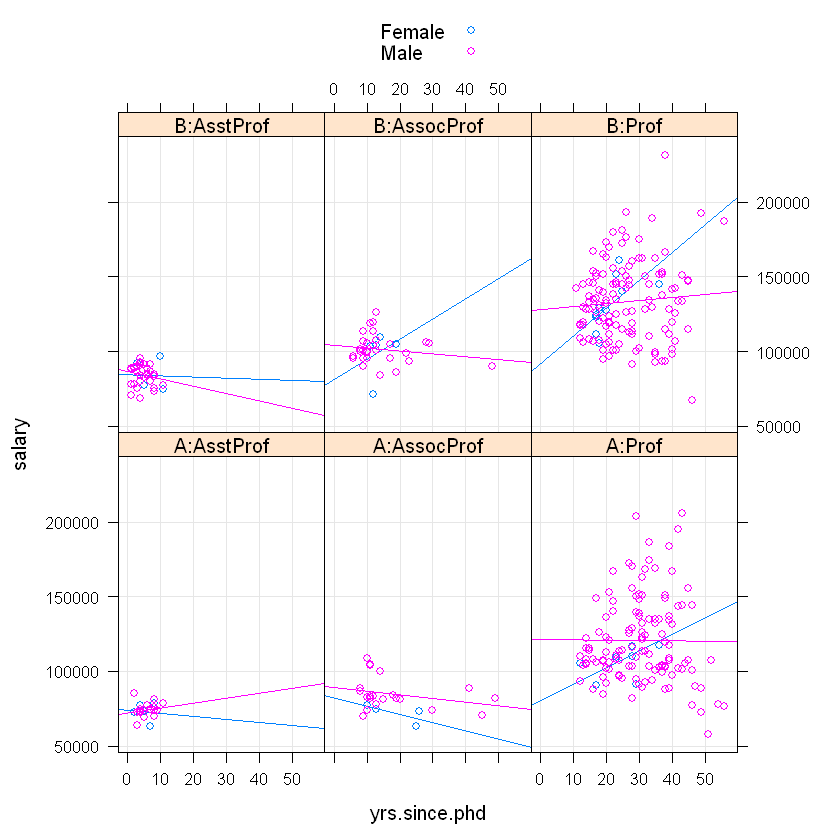

In [119]:
# Let's look at the data format
some(Salaries)
nrow(Salaries)

# let's relevel the factor rank
Salaries$rank <- relevel(Salaries$rank, ref="AsstProf")

# Making a table to see how many subjects in each category
# xtabs make a table and ftable "flattens" the table
ftable(x1 <- xtabs(~ discipline + rank + sex, data=Salaries))
round(100*ftable(prop.table(x1, margin=c(1, 2))), 1) # % m and f

# We are plotting the data
library(lattice)
xyplot(salary ~ yrs.since.phd | discipline:rank, group=sex,
  data=Salaries, type=c("g", "p", "r"), auto.key=TRUE)


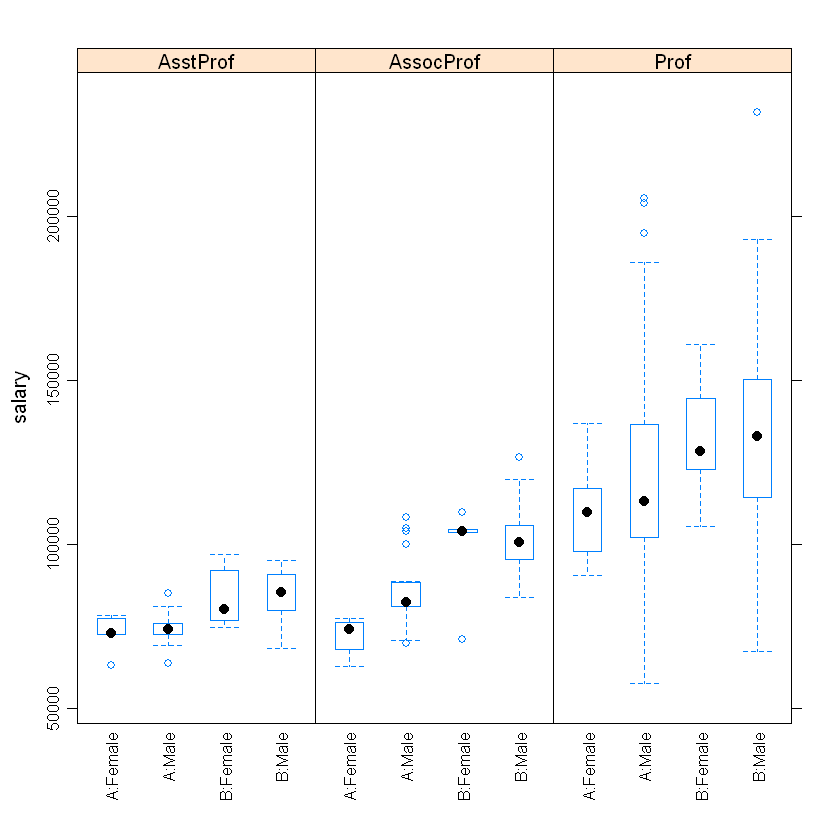

In [120]:

bwplot(salary ~ discipline:sex | rank, data=Salaries,
    scales=list(rot=90), layout=c(3, 1))



#### Getting baseline predictions

In [121]:
# Generate a model for Males only
fselector <- Salaries$sex == "Female" # TRUE for females
salmod <- lm(salary ~ rank*discipline + yrs.since.phd, data=Salaries,
    subset=!fselector) # regression for males
    
# predictions for females:
femalePreds <- predict(salmod, newdata=Salaries[fselector, ])
(meanDiff <- mean(Salaries$salary[fselector] - femalePreds))

[1] -4550.51

#### Bootstrapping

In [122]:

# Let's do a bootstrap to see how often we could get this result
set.seed(8141976) # for reproducibility
fnumber <- sum(fselector) # number of females
n <- length(fselector) # number of observations
B <- 2 # number of replications
simDiff <- numeric(B) # initialize vector with B entries
for (j in 1:B){
    sel <- sample(1:n, fnumber) # random sample of nominated 'females'
    m2 <- update(salmod, subset=-sel) # refit regression model
    simDiff[j] <- mean(Salaries$salary[sel]
        - predict(m2, newdata=Salaries[sel, ])) # compute mean diff.
    }
    
# Calculate the p-value    
(frac <- round(sum(meanDiff > simDiff)/(1 + B), 3))

[1] 0

#### Plotting

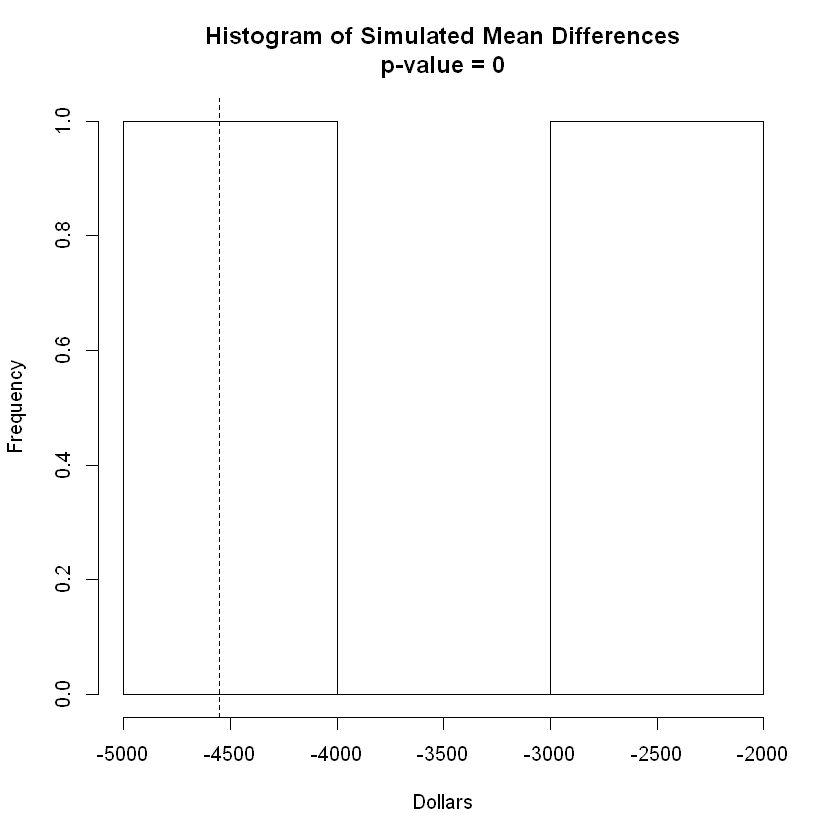

In [123]:
hist(simDiff,
   main=paste("Histogram of Simulated Mean Differences\np-value =",
       frac),
   xlab="Dollars")
abline(v=meanDiff, lty="dashed")